### Create AUC curves

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from confidenceinterval import roc_auc_score, accuracy_score

### Load all of the prediction files

In [2]:
# Define file paths for each category
file_paths = [
    'path/to/s4_predictions',
    'path/to/resnet6_predictions',
    'path/to/resnet18_predictions',
    'path/to/resnet50_predictions',
]

# Function to load and rename preds column based on model name
def load_and_rename(file_paths):
    # Load the first dataframe
    merged_df = pd.read_csv(file_paths[0])
    model_name = file_paths[0].split('/')[-1].split('_test_val_train_predictions_')[0]
    merged_df = merged_df.rename(columns={'preds': f'preds_{model_name}'})
    merged_df = merged_df.rename(columns={'binary_preds': f'binary_preds_{model_name}'})
    
    # Iterate over the rest of the file paths and merge
    for file_path in file_paths[1:]:
        # Extract model name from file path
        model_name = file_path.split('/')[-1].split('_test_val_train_predictions_')[0]
        
        # Load the dataframe
        df = pd.read_csv(file_path)
        
        # Rename the 'preds' column to include the model name
        df = df.rename(columns={'preds': f'preds_{model_name}'})
        df = df.rename(columns={'binary_preds': f'binary_preds_{model_name}'})
        
        # Merge on 'curve_idx'
        merged_df = pd.merge(merged_df, df[['curve_idx', f'preds_{model_name}', f'binary_preds_{model_name}']], on='curve_idx', how='inner')
    
    return merged_df

# Load and merge dataframes for each category
tested_df = load_and_rename(file_paths)

In [3]:
df_test = pd.read_csv('path/to/evaluation_data')
df_test['curve_idx'] = df_test['ecg_id'].str.replace('ecg', '')
tested_df = tested_df.merge(df_test[['curve_idx', 'preds_ste_sti_twi_logist', 'binary_preds_ste_sti_twi_logist', 'has_twave_inver', 'has_st_eleva', 'has_depress','test_010_day', 'stress_010_day', 'cath_010_day', 'has_twave_abnormal']], on='curve_idx', how='left')

### Add HuBERT-ECG Preds

In [4]:
hubert_acs = (
    pd.read_csv('path/to/HuBERT_ecg_preds')
    .assign(
        curve_idx=lambda df: df['Filename'].str[:-4],
        preds_hubert_full=lambda df: df['Probability_Pos']
    )
)

# Merge label and last layer predictions into hubert_acs_full
hubert_acs = hubert_acs.merge(tested_df[['curve_idx', 'label']], how='left', on='curve_idx')

columns_to_add = ['preds_hubert_full']
if not all(col in tested_df.columns for col in columns_to_add):
    tested_df = tested_df.merge(
        hubert_acs[['curve_idx'] + columns_to_add],
        how='left',
        on='curve_idx'
    )

### AUC curves

In [5]:
def plot_auroc_curve(df, label_column='label', title='AUROC Curve', savepath=None):
    # Define ML models and ECG features
    ml_models = {
        'preds_state': 'S4-ECG',
        'preds_resnet18_1d': 'ResNet-18',
        'preds_hubert_full': 'HuBERT-ECG'
        
    }
    ecg_features_binary = ['has_st_eleva',  'has_depress', 'has_twave_inver', 'has_twave_abnormal']
    ecg_feature_continuous = 'preds_ste_sti_twi_logist'

    # Define the color palette from the provided image
    color_palette = ['#ee5d6c', '#0317fc', '#789bf5', '#55f4fa']
    ecg_color = color_palette[0]  # Shared color for ECG features (both binary and continuous)
    ml_colors = color_palette[1:]  # Remaining colors for ML models

    plt.figure(figsize=(10, 8))
    #plt.title(title, fontsize=14)

    # Plot ML models
    for i, (col, label) in enumerate(ml_models.items()):
        if col in df.columns:
            fpr, tpr, _ = roc_curve(df[label_column], df[col])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=ml_colors[i % len(ml_colors)], linewidth=2)

    # Plot binary ECG features as dots
    markers = ['X','P','p','o']
    name = ['ST elevation', 'ST depression', 'T-wave inversion', 'T-wave abnormal']
    for i, feat in enumerate(ecg_features_binary):
        if feat in df.columns:
            fpr, tpr, _ = roc_curve(df[label_column], df[feat])
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr[1], tpr[1],
                linestyle='',
                marker=markers[i],
                color=ecg_color,
                markersize=8,
                label=f"{name[i]} (AUC = {roc_auc:.2f})" #f'{feat.replace("has_", "").replace("_", " ").title()} (AUC = {roc_auc:.2f})'
            )

    # Plot continuous ECG feature
    if ecg_feature_continuous in df.columns:
        fpr, tpr, _ = roc_curve(df[label_column], df[ecg_feature_continuous])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'Logistic regression (ECG features) (AUC = {roc_auc:.2f})', color=ecg_color, linewidth=1.5)

    # Add diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(False)

    # Save plot if savepath is specified
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

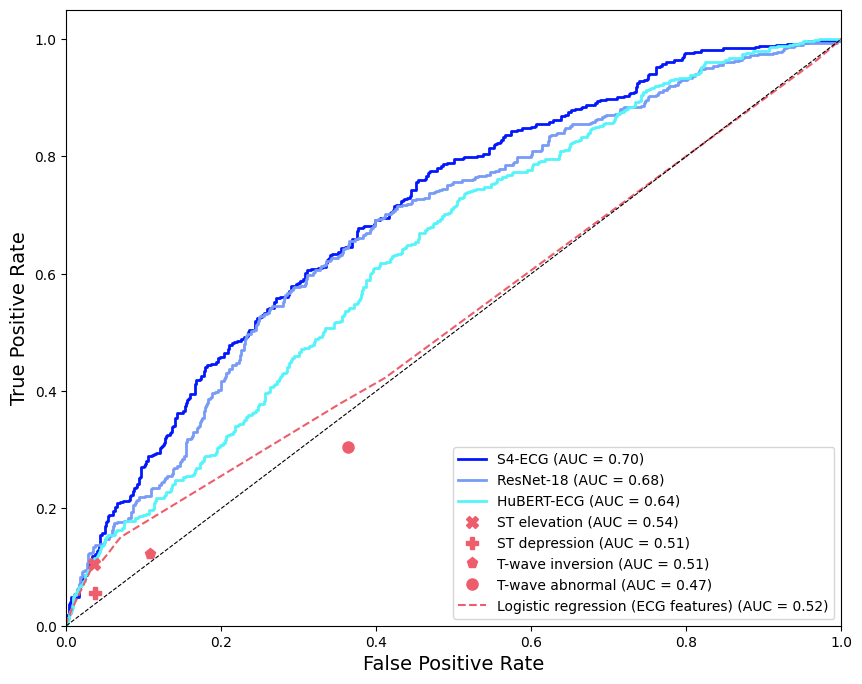

In [6]:
plot_auroc_curve(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_resnet18_1d', 'preds_hubert_full', 'preds_state']],
    label_column='label',
    title='Tested Population AUROC Curve',
    savepath="auc_curve_tested_pop.png"
)

#### Alternative version only including best ML model

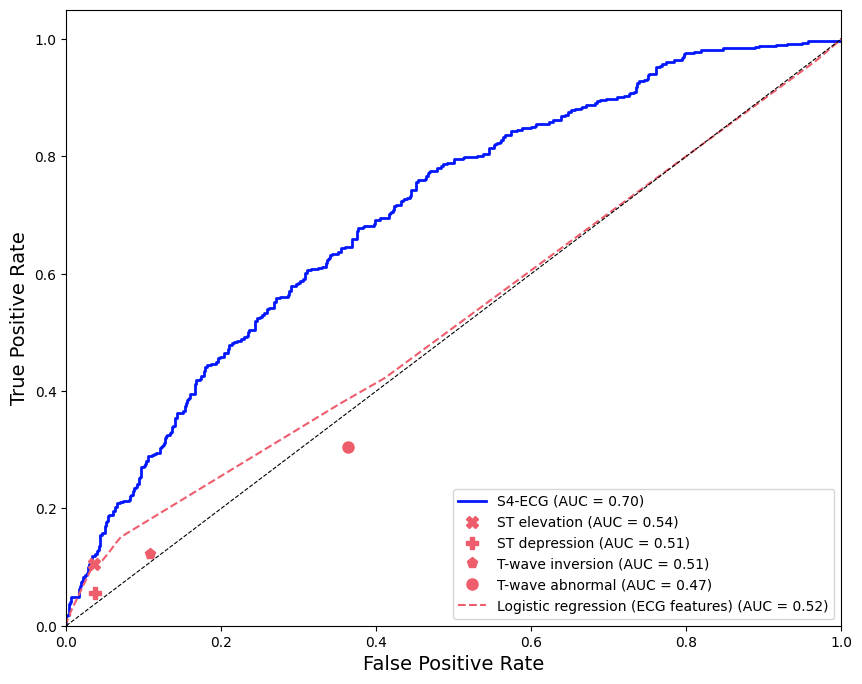

In [7]:
plot_auroc_curve(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_state']],
    label_column='label',
    title='Tested Population AUROC Curve',
    savepath="auc_curve_tested_pop_only_s4.png"
)

#### Supplement: AUC curve for resnets of different depth

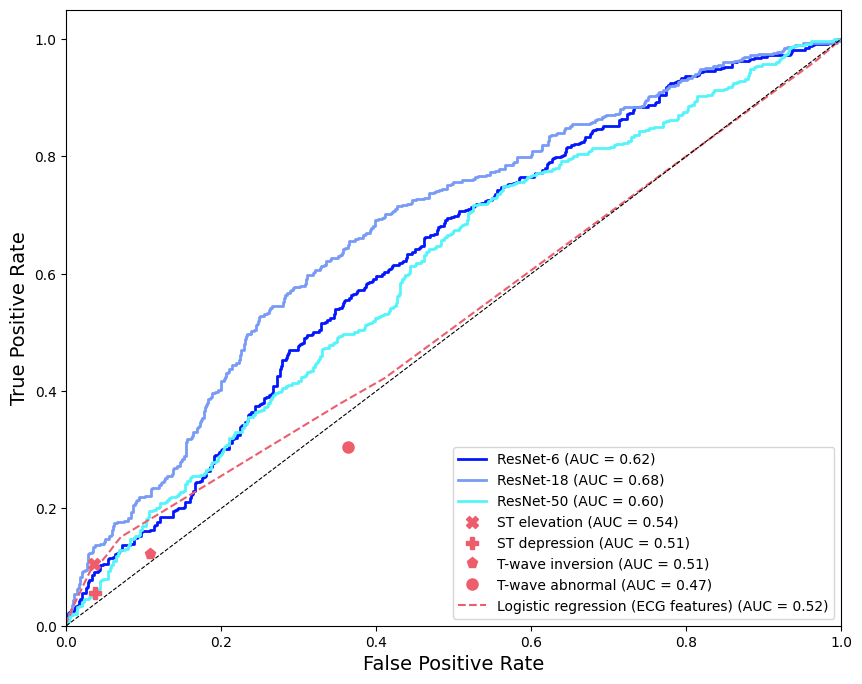

In [8]:
def plot_auroc_supplement(df, label_column='label', title='AUROC Curve', savepath=None):
    # Define ML models and ECG features
    ml_models = {
        'preds_ecgomi': 'ResNet-6',
        'preds_resnet18_1d': 'ResNet-18',
        'preds_resnet50_1d': 'ResNet-50'
        
    }
    ecg_features_binary = ['has_st_eleva',  'has_depress', 'has_twave_inver', 'has_twave_abnormal']
    ecg_feature_continuous = 'preds_ste_sti_twi_logist'

    # Define the color palette from the provided image
    color_palette = ['#ee5d6c', '#0317fc', '#789bf5', '#55f4fa']
    ecg_color = color_palette[0]  # Shared color for ECG features (both binary and continuous)
    ml_colors = color_palette[1:]  # Remaining colors for ML models

    plt.figure(figsize=(10, 8))
    #plt.title(title, fontsize=14)

    # Plot ML models
    for i, (col, label) in enumerate(ml_models.items()):
        if col in df.columns:
            fpr, tpr, _ = roc_curve(df[label_column], df[col])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=ml_colors[i % len(ml_colors)], linewidth=2)

    # Plot binary ECG features as dots
    markers = ['X','P','p','o']
    name = ['ST elevation', 'ST depression', 'T-wave inversion', 'T-wave abnormal']
    for i, feat in enumerate(ecg_features_binary):
        if feat in df.columns:
            fpr, tpr, _ = roc_curve(df[label_column], df[feat])
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr[1], tpr[1],
                linestyle='',
                marker=markers[i],
                color=ecg_color,
                markersize=8,
                label=f"{name[i]} (AUC = {roc_auc:.2f})" #f'{feat.replace("has_", "").replace("_", " ").title()} (AUC = {roc_auc:.2f})'
            )

    # Plot continuous ECG feature
    if ecg_feature_continuous in df.columns:
        fpr, tpr, _ = roc_curve(df[label_column], df[ecg_feature_continuous])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'Logistic regression (ECG features) (AUC = {roc_auc:.2f})', color=ecg_color, linewidth=1.5)

    # Add diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(False)

    # Save plot if savepath is specified
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()


# Call the function for the tested population #'preds_seer_finetuned', 'preds_seer_pretrained', 'preds_seer_scratch', 'preds_seer_pretrained', 'preds_seer_scratch', 'preds_hubert_last_layer', 
plot_auroc_supplement(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_resnet18_1d', 'preds_ecgomi', 'preds_resnet50_1d']],
    label_column='label',
    title='Tested Population AUROC Curve',
    savepath="auc_curve_tested_pop_appendix.png"
)

#### Additional Statistics: AUC for all ACS predictors with 95% confidence interval  

In [9]:
columns_to_evaluate = [
    'has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 
    'preds_ste_sti_twi_logist', 'has_depress', 'preds_resnet18_1d', 'preds_ecgomi', 'preds_resnet50_1d', 
    'preds_hubert_full', 'preds_state'
]

# Results dictionary
results = []

# Calculate AUC and 95% CI for each feature
for column in columns_to_evaluate:
    auc_data, (ci_lower, ci_upper) = roc_auc_score(tested_df['label'], tested_df[column], confidence=0.95)
    results.append({
        "Feature": column,
        "AUC": round(auc_data, 3),
        "95% CI Lower": round(ci_lower, 3),
        "95% CI Upper": round(ci_upper, 3)
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)
 
display(results_df)

,Feature,AUC,95% CI Lower,95% CI Upper
0,has_twave_inver,0.507,0.489,0.524
1,has_st_eleva,0.535,0.520,0.550
2,has_twave_abnormal,0.471,0.445,0.497
3,preds_ste_sti_twi_logist,0.522,0.492,0.552
4,has_depress,0.510,0.498,0.522
5,preds_resnet18_1d,0.677,0.647,0.706
6,preds_ecgomi,0.625,0.594,0.655
7,preds_resnet50_1d,0.603,0.572,0.635
8,preds_hubert_full,0.637,0.607,0.667
9,preds_state,0.703,0.674,0.731


### Cumulative risk curve

Mean event rate: 0.3876


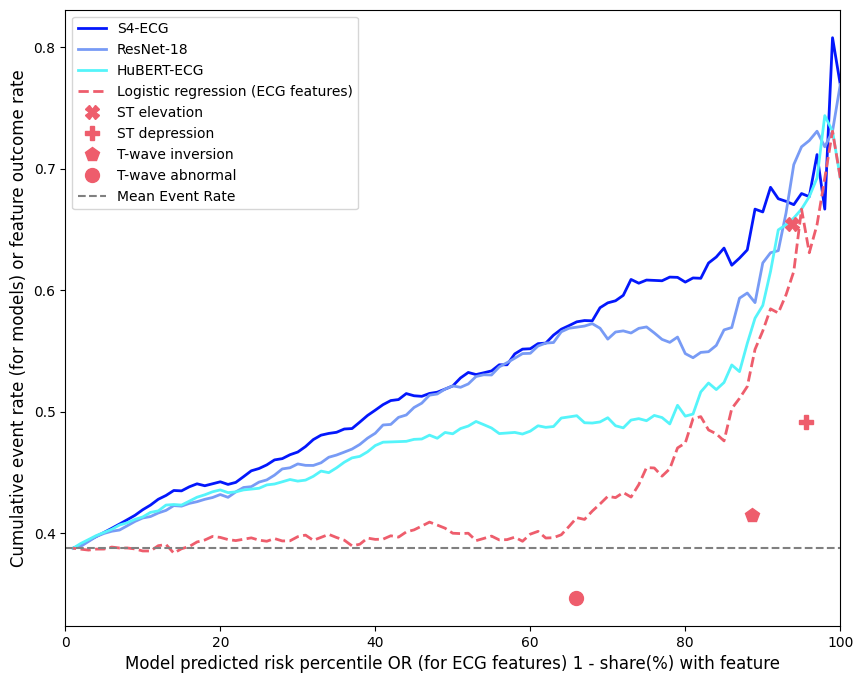

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

def plot_cumulative_risk(df, label_column='label', title='Cumulative Risk per Percentile', savepath=None):
    plt.figure(figsize=(10, 8))

    # Define the models and features as in the AUROC code
    ml_models = {
        'preds_state': 'S4-ECG',
        'preds_resnet18_1d': 'ResNet-18',
        'preds_hubert_full': 'HuBERT-ECG'
    }

    ecg_features_binary = ['has_st_eleva', 'has_depress', 'has_twave_inver', 'has_twave_abnormal']
    ecg_binary_names = ['ST elevation', 'ST depression', 'T-wave inversion', 'T-wave abnormal']
    ecg_feature_continuous = 'preds_ste_sti_twi_logist'
    ecg_cont_label = 'Logistic regression (ECG features)'

    # Colors and markers as per AUROC code
    # AUROC code colors: ecg_color = '#ee5d6c', ml_colors = ['#0317fc', '#789bf5', '#55f4fa']
    ecg_color = '#ee5d6c'
    ml_colors = ['#0317fc', '#789bf5', '#55f4fa']
    model_color_map = {
        'S4-ECG': ml_colors[0],
        'ResNet-18': ml_colors[1],
        'HuBERT-ECG': ml_colors[2]
    }

    # Binary ECG features markers as per AUROC code
    ecg_markers = ['X', 'P', 'p', 'o']

    percentiles = 100

    # Calculate mean event rate for the whole population
    mean_event_rate = df[label_column].mean()
    print(f"Mean event rate: {mean_event_rate:.4f}")

    # Helper function to calculate cumulative risk
    def calculate_cumulative_risk(data, pred_col):
        df_sorted = data.sort_values(by=pred_col, ascending=False).reset_index(drop=True)
        df_sorted['percentile'] = pd.qcut(df_sorted.index, q=percentiles, labels=False)
        cumulative_risk = (df_sorted.groupby('percentile')[label_column].sum().cumsum() /
                           df_sorted.groupby('percentile').size().cumsum())
        return cumulative_risk

    # Plot ML models (cumulative curves)
    for col, label_name in ml_models.items():
        if col in df.columns:
            cumulative_risk = calculate_cumulative_risk(df, col)
            plt.plot(
                range(percentiles, 0, -1),
                cumulative_risk,
                label=label_name,
                color=model_color_map[label_name],
                linestyle='-',
                linewidth=2
            )

    # Plot continuous ECG feature (logistic regression) as a cumulative curve
    if ecg_feature_continuous in df.columns:
        cumulative_risk = calculate_cumulative_risk(df, ecg_feature_continuous)
        plt.plot(
            range(percentiles, 0, -1),
            cumulative_risk,
            label=ecg_cont_label,
            color=ecg_color,
            linestyle='--',
            linewidth=2
        )


    # Plot binary ECG features as single points:
    # x = (1 - share_of_people_with_feature)*100
    # y = outcome_rate_in_those_with_feature
    for i, feat in enumerate(ecg_features_binary):
        if feat in df.columns:
            share_with_feature = df[feat].mean()
            outcome_rate = df.loc[df[feat] == 1, label_column].mean() if df[feat].sum() > 0 else np.nan
            x_value = (1 - share_with_feature) * 100
            y_value = outcome_rate
            
            # Only plot if we have a valid outcome rate
            if pd.notnull(y_value):
                plt.plot(
                    x_value,
                    y_value,
                    marker=ecg_markers[i],
                    color=ecg_color,
                    linestyle='',
                    markersize=10,
                    label=ecg_binary_names[i]
                )

    # Plot mean event rate as a reference line
    plt.axhline(y=mean_event_rate, color='grey', linestyle='--', linewidth=1.5, label='Mean Event Rate')

    # Formatting
    plt.xlabel('Model predicted risk percentile OR (for ECG features) 1 - share(%) with feature', size=12)
    plt.ylabel('Cumulative event rate (for models) or feature outcome rate', size=12)
    #plt.title(title, fontsize=16)
    plt.legend(loc='upper left', fontsize=10)
    plt.xlim(0, 100)
    plt.grid(False)

    # Save plot if requested
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_cumulative_risk(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_resnet18_1d', 'preds_hubert_full', 'preds_state']],
    label_column='label',
    title='Cumulative Risk - Tested Population',
    savepath="cumulative_risk_tested_pop.png"
)

#### Alternative version only reporting results for the best ML model

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

def plot_cumulative_risk_alternative(df, label_column='label', title='Cumulative Risk per Percentile', savepath=None):
    plt.figure(figsize=(10, 8))

    # Define the models and features as in the AUROC code
    ml_models = {
        'preds_state': 'S4-ECG',
        'preds_resnet18_1d': 'ResNet-18',
        'preds_hubert_full': 'HuBERT-ECG'
    }

    ecg_features_binary = ['has_st_eleva', 'has_depress', 'has_twave_inver', 'has_twave_abnormal']
    ecg_binary_names = ['ST elevation', 'ST depression', 'T-wave inversion', 'T-wave abnormal']
    ecg_feature_continuous = 'preds_ste_sti_twi_logist'
    ecg_cont_label = 'Logistic regression (ECG features)'

    # Colors and markers as per AUROC code
    # AUROC code colors: ecg_color = '#ee5d6c', ml_colors = ['#0317fc', '#789bf5', '#55f4fa']
    ecg_color = '#ee5d6c'
    ml_colors = ['#0317fc', '#789bf5', '#55f4fa']
    model_color_map = {
        'S4-ECG': ml_colors[0],
        'ResNet-18': ml_colors[1],
        'HuBERT-ECG': ml_colors[2]
    }

    # Binary ECG features markers as per AUROC code
    ecg_markers = ['X', 'P', 'p', 'o']

    percentiles = 100

    # Calculate mean event rate for the whole population
    mean_event_rate = df[label_column].mean()
    print(f"Mean event rate: {mean_event_rate:.4f}")

    # Helper function to calculate cumulative risk
    def calculate_cumulative_risk(data, pred_col):
        df_sorted = data.sort_values(by=pred_col, ascending=False).reset_index(drop=True)
        df_sorted['percentile'] = pd.qcut(df_sorted.index, q=percentiles, labels=False)
        cumulative_risk = (df_sorted.groupby('percentile')[label_column].sum().cumsum() /
                           df_sorted.groupby('percentile').size().cumsum())
        return cumulative_risk

    # Plot ML models (cumulative curves)
    for col, label_name in ml_models.items():
        if col in df.columns:
            cumulative_risk = calculate_cumulative_risk(df, col)
            plt.plot(
                range(percentiles, 0, -1),
                cumulative_risk,
                label=label_name,
                color=model_color_map[label_name],
                linestyle='-',
                linewidth=2
            )


    # Plot continuous ECG feature (logistic regression) as a cumulative curve
    if ecg_feature_continuous in df.columns:
        cumulative_risk = calculate_cumulative_risk(df, ecg_feature_continuous)
        plt.plot(
            range(percentiles, 0, -1),
            cumulative_risk,
            label=ecg_cont_label,
            color=ecg_color,
            linestyle='--',
            linewidth=2
        )

    for i, feat in enumerate(ecg_features_binary):
        if feat in df.columns:
            share_with_feature = df[feat].mean()
            outcome_rate = df.loc[df[feat] == 1, label_column].mean() if df[feat].sum() > 0 else np.nan
            x_value = (1 - share_with_feature) * 100
            y_value = outcome_rate
            
            # Only plot if we have a valid outcome rate
            if pd.notnull(y_value):
                plt.plot(
                    x_value,
                    y_value,
                    marker=ecg_markers[i],
                    color=ecg_color,
                    linestyle='',
                    markersize=10,
                    label=ecg_binary_names[i]
                )

    # Plot a vertical dashed darkgrey line at 100-(population_prevalence*100)
    vertical_line_x = 100 - (mean_event_rate * 100)
    plt.axvline(x=vertical_line_x, color='darkgrey', linestyle='--', linewidth=1.5, label='Population prevalence')

    # Formatting
    plt.xlabel('Model predicted risk percentile OR (for ECG features) 1 - share(%) with feature', size=12)
    plt.ylabel('Cumulative event rate (for models) or feature outcome rate', size=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xlim(0, 100)
    plt.grid(False)

    # Save plot if requested
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

Mean event rate: 0.3876


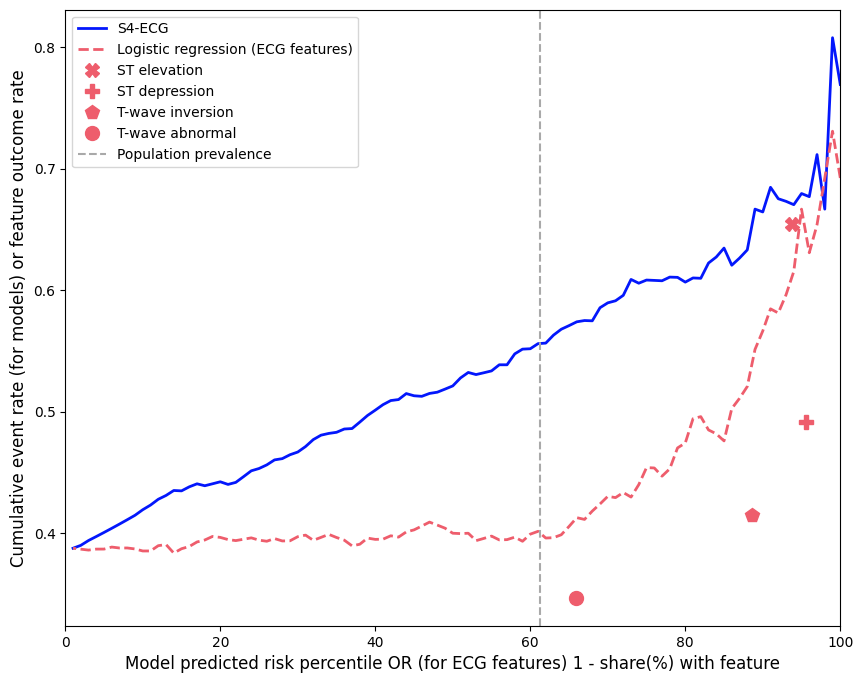

In [12]:
plot_cumulative_risk_alternative(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_state']],
    label_column='label',
    title='Cumulative Risk - Tested Population',
    savepath="cumulative_risk_tested_pop_only_state.png"
)

#### Supplement version for ResNet models of different depth

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

def plot_cumulative_risk_supplement(df, label_column='label', title='Cumulative Risk per Percentile', savepath=None):
    plt.figure(figsize=(10, 8))

    # Define the models and features as in the AUROC code
    ml_models = {
        'preds_ecgomi': 'ResNet-6',
        'preds_resnet18_1d': 'ResNet-18',
        'preds_resnet50_1d': 'ResNet-50'
    }

    ecg_features_binary = ['has_st_eleva', 'has_depress', 'has_twave_inver', 'has_twave_abnormal']
    ecg_binary_names = ['ST elevation', 'ST depression', 'T-wave inversion', 'T-wave abnormal']
    ecg_feature_continuous = 'preds_ste_sti_twi_logist'
    ecg_cont_label = 'Logistic regression (ECG features)'

    # Colors and markers as per AUROC code
    ecg_color = '#ee5d6c'
    ml_colors = ['#0317fc', '#789bf5', '#55f4fa']
    model_color_map = {
        'ResNet-6': ml_colors[0],
        'ResNet-18': ml_colors[1],
        'ResNet-50': ml_colors[2]
    }

    # Binary ECG features markers as per AUROC code
    ecg_markers = ['X', 'P', 'p', 'o']

    percentiles = 100

    # Calculate mean event rate for the whole population
    mean_event_rate = df[label_column].mean()
    print(f"Mean event rate: {mean_event_rate:.4f}")

    # Helper function to calculate cumulative risk
    def calculate_cumulative_risk(data, pred_col):
        df_sorted = data.sort_values(by=pred_col, ascending=False).reset_index(drop=True)
        df_sorted['percentile'] = pd.qcut(df_sorted.index, q=percentiles, labels=False)
        cumulative_risk = (df_sorted.groupby('percentile')[label_column].sum().cumsum() /
                           df_sorted.groupby('percentile').size().cumsum())
        return cumulative_risk

    # Plot ML models (cumulative curves)
    for col, label_name in ml_models.items():
        if col in df.columns:
            cumulative_risk = calculate_cumulative_risk(df, col)
            plt.plot(
                range(percentiles, 0, -1),
                cumulative_risk,
                label=label_name,
                color=model_color_map[label_name],
                linestyle='-',
                linewidth=2
            )

    # Plot continuous ECG feature (logistic regression) as a cumulative curve
    if ecg_feature_continuous in df.columns:
        cumulative_risk = calculate_cumulative_risk(df, ecg_feature_continuous)
        plt.plot(
            range(percentiles, 0, -1),
            cumulative_risk,
            label=ecg_cont_label,
            color=ecg_color,
            linestyle='--',
            linewidth=2
        )

    for i, feat in enumerate(ecg_features_binary):
        if feat in df.columns:
            share_with_feature = df[feat].mean()
            outcome_rate = df.loc[df[feat] == 1, label_column].mean() if df[feat].sum() > 0 else np.nan
            x_value = (1 - share_with_feature) * 100
            y_value = outcome_rate
            
            # Only plot if we have a valid outcome rate
            if pd.notnull(y_value):
                plt.plot(
                    x_value,
                    y_value,
                    marker=ecg_markers[i],
                    color=ecg_color,
                    linestyle='',
                    markersize=10,
                    label=ecg_binary_names[i]
                )

    # Plot mean event rate as a reference line
    plt.axhline(y=mean_event_rate, color='grey', linestyle='--', linewidth=1.5, label='Mean Event Rate')

    # Formatting
    plt.xlabel('Model predicted risk percentile OR (for ECG features) 1 - share(%) with feature', size=12)
    plt.ylabel('Cumulative event rate (for models) or feature outcome rate', size=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.xlim(0, 100)
    plt.grid(False)

    # Save plot if requested
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

Mean event rate: 0.3876


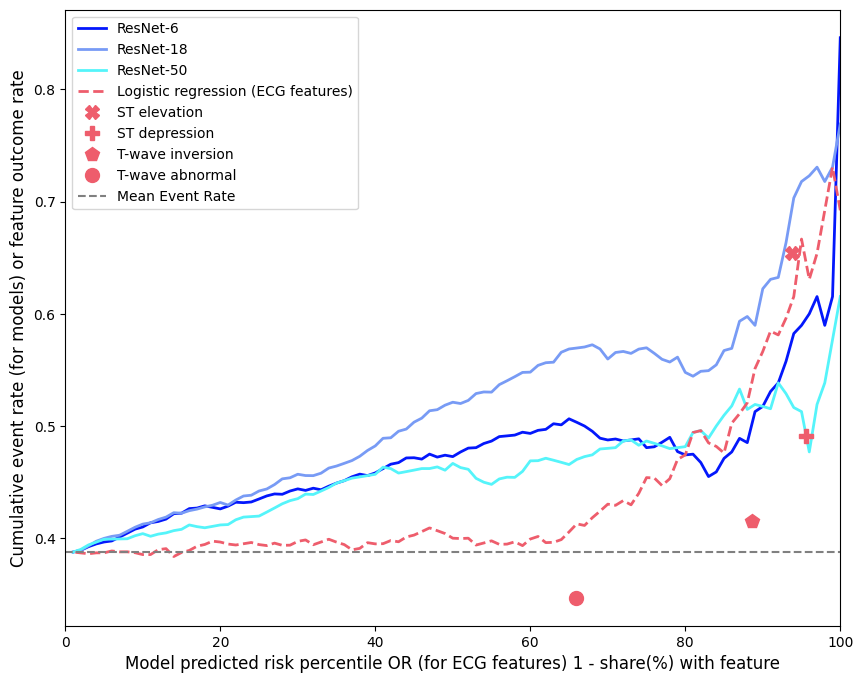

In [14]:
# Example usage
plot_cumulative_risk_supplement(
    df=tested_df[['label','has_twave_inver', 'has_st_eleva', 'has_twave_abnormal', 'preds_ste_sti_twi_logist', 'has_depress', 'preds_ecgomi', 'preds_resnet18_1d', 'preds_resnet50_1d']],
    label_column='label',
    title='Cumulative Risk - Tested Population',
    savepath="cumulative_risk_tested_pop_appendix.png"
)

### Transform risk scores into binary labels

In [15]:
def generate_binary_predictions(df, label_column='label'):
    """
    Generates binary predictions for each model in the dataframe.
    The number of positive predictions equals the number of positive labels.
    """
    n_positive_labels = int(df[label_column].sum())
    n_samples = len(df)
    positives = df[label_column].sum()
    
    print(f"Total samples: {n_samples}")
    print(f"Event rate (mean_event_rate): {positives / n_samples:.4f}")
    print()

    for col in df.columns:
        if col.startswith('preds_') or col in ['has_twave_inver', 'has_st_eleva', 'has_depress']:
            pred_min = df[col].min()
            # Get the indices of the predictions sorted in descending order
            sorted_indices = df[col].sort_values(ascending=False).index

            # Initialize binary predictions to zeros
            binary_col_name = 'binary_' + col
            df[binary_col_name] = 0

            # Set the first n_positive_labels indices to 1
            df.loc[sorted_indices[:n_positive_labels], binary_col_name] = 1
            
            df[binary_col_name] = ((df[binary_col_name]==1) & (df[col]>pred_min)).astype(int)

            # Calculate the share of positive predictions
            positive_predictions = df[binary_col_name].sum()
            share_positive_predictions = positive_predictions / n_samples
            
            positive_cases = df[df[binary_col_name]==1]

            print(f"Model: {col}")
            
            auc, ci = roc_auc_score(df['label'], df[col],
                        confidence_level=0.95)
            
            print(f'Test AUC Score: {round(auc,3)} ({round(ci[0],3)}, {round(ci[1],3)})')
            
            acc, ci_acc = accuracy_score(df['label'], df[binary_col_name],
                        confidence_level=0.95)

            print(f'Test Accuracy Score: {round(acc,3)} ({round(ci_acc[0],3)}, {round(ci_acc[1],3)})')
            
            acc, ci_acc = accuracy_score(positive_cases['label'], positive_cases[binary_col_name],
                        confidence_level=0.95)

            print(f'Test PPV: {acc} ({ci_acc[0]}, {ci_acc[1]})')
            print()
            
    return df 

# Apply the function to each dataframe
tested_df = generate_binary_predictions(tested_df, label_column='label')

Total samples: 1295
Event rate (mean_event_rate): 0.3876

Model: preds_state
Test AUC Score: 0.703000009059906 (0.674, 0.731)
Test Accuracy Score: 0.659 (0.632, 0.684)
Test PPV: 0.5597609561752988 (0.5160447447790776, 0.6025694948284911)

Model: preds_ecgomi
Test AUC Score: 0.625 (0.594, 0.655)
Test Accuracy Score: 0.611 (0.584, 0.637)
Test PPV: 0.49800796812749004 (0.4544510990994606, 0.5415950929136205)

Model: preds_resnet18_1d
Test AUC Score: 0.6769999861717224 (0.647, 0.706)
Test Accuracy Score: 0.656 (0.629, 0.681)
Test PPV: 0.5557768924302788 (0.5120508611811192, 0.5986557624526117)

Model: preds_resnet50_1d
Test AUC Score: 0.6029999852180481 (0.572, 0.635)
Test Accuracy Score: 0.592 (0.565, 0.619)
Test PPV: 0.47410358565737054 (0.430785944169724, 0.5178145520003294)

Model: preds_ste_sti_twi_logist
Test AUC Score: 0.5220000147819519 (0.492, 0.552)
Test Accuracy Score: 0.531 (0.503, 0.558)
Test PPV: 0.3944223107569721 (0.3526266489525521, 0.43782152774074273)

Model: has_twave_i

### Load further metadata

In [16]:
testing_meta = pd.read_csv("path/to/metadata")
testing_meta['curve_idx'] = testing_meta['ecg_id_new'].str.replace('.npy', '', regex=False)
testing_meta['ste_std_twi'] = testing_meta[['has_st_eleva', 'has_twave_inver', 'has_depress', 'has_twave_abnormal']].any(axis=1)

testing_meta = testing_meta[['curve_idx',
       'age_at_admit', 'macetrop_030_pos', 'death_030_day',
        'stent_010_day', 'cabg_010_day',
        'ami_day_of', 'days_to_ami', 'maxtrop_sameday', 'stent_or_cabg_010_day','macetrop_pos_or_death_030',
       'tn_group_sameday', 'disch_disp', 'disch_obs', 'test_010_day',
       'stress_010_day', 'cath_010_day', 'race_black', 'race_hispanic',
       'race_white', 'race_other', 'agi_under_25k', 'agi_25k_to_50k',
       'agi_50k_to_75k', 'agi_75k_to_100k', 'agi_100k_to_200k',
       'agi_above_200k', 'female',
         'ste_std_twi']] #'has_twave_inver', 'has_depress', 'has_st_eleva',

tested_df = tested_df.merge(testing_meta, how='left', on='curve_idx')

### Analyze AUC by race and gender

In [17]:
import pandas as pd
import numpy as np

def calculate_auc_per_subgroup(df, target_col):
    # Define model prediction columns
    model_cols = [col for col in df.columns if col.startswith('preds') and not col.startswith('binary')]
    
    # Define subgroups
    subgroups = {
        'All': df,
        'Female': df[df['female'] == True],
        'Male': df[df['female'] == False],
        'Race_Black': df[df['race_black'] == True],
        'Race_Hispanic': df[df['race_hispanic'] == True],
        'Race_White': df[df['race_white'] == True],
        'Race_Other': df[df['race_other'] == True]
    }
    
    # Initialize results dictionary
    results = {model: {} for model in model_cols}
    
    # Calculate AUC for each model and each subgroup
    for model in model_cols:
        for subgroup_name, subgroup_data in subgroups.items():
            if len(subgroup_data) > 0:

                auc, ci = roc_auc_score(subgroup_data[target_col], subgroup_data[model],
                        confidence_level=0.95)

                results[model][subgroup_name] = f'{auc:.3f} ({round(ci[0],3)}, {round(ci[1],3)})'
            else:
                results[model][subgroup_name] = np.nan
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).transpose()
    results_df.columns.name = "Subgroups"
    results_df.index.name = "Model"
    
    return results_df

In [18]:
# Example usage
auc_results = calculate_auc_per_subgroup(tested_df, 'label')
display(auc_results)

Subgroups,All,Female,Male,Race_Black,Race_Hispanic,Race_White,Race_Other
Model,,,,,,,
preds_state,"0.703 (0.674, 0.731)","0.710 (0.665, 0.755)","0.695 (0.658, 0.733)","0.780 (0.714, 0.846)","0.665 (0.576, 0.754)","0.692 (0.656, 0.727)","0.697 (0.567, 0.827)"
preds_ecgomi,"0.625 (0.594, 0.655)","0.585 (0.534, 0.635)","0.644 (0.604, 0.683)","0.617 (0.543, 0.69)","0.567 (0.471, 0.664)","0.635 (0.598, 0.673)","0.659 (0.527, 0.792)"
preds_resnet18_1d,"0.677 (0.647, 0.706)","0.655 (0.606, 0.704)","0.700 (0.663, 0.738)","0.731 (0.662, 0.8)","0.651 (0.559, 0.743)","0.677 (0.64, 0.713)","0.647 (0.511, 0.783)"
preds_resnet50_1d,"0.603 (0.572, 0.635)","0.567 (0.515, 0.619)","0.633 (0.594, 0.673)","0.542 (0.461, 0.622)","0.590 (0.493, 0.686)","0.622 (0.584, 0.66)","0.571 (0.429, 0.713)"
preds_ste_sti_twi_logist,"0.522 (0.492, 0.552)","0.550 (0.5, 0.599)","0.507 (0.47, 0.545)","0.514 (0.44, 0.588)","0.514 (0.422, 0.606)","0.523 (0.487, 0.559)","0.592 (0.458, 0.726)"
preds_hubert_full,"0.637 (0.607, 0.667)","0.610 (0.559, 0.66)","0.656 (0.618, 0.695)","0.680 (0.609, 0.751)","0.719 (0.635, 0.804)","0.613 (0.575, 0.651)","0.630 (0.494, 0.766)"


### Testing yield analysis

In [19]:
# Update the dictionary of models/features to those of interest
models = {
    'S4-ECG': 'binary_preds_state',
    'ResNet-18': 'binary_preds_resnet18_1d',
    'HuBERT-ECG': 'binary_preds_hubert_full',
    'Logistic regression (ECG features)': 'binary_preds_ste_sti_twi_logist',
    'ST elevation': 'has_st_eleva',
    'ST depression': 'has_depress',
    'T-wave inversion': 'has_twave_inver',
    'T-wave abnormal': 'has_twave_abnormal',
    #'Any guideline feature': 'ste_std_twi'
}

# Ensure ste_std_twi is defined properly
tested_df['ste_std_twi'] = tested_df[['has_st_eleva', 'has_twave_inver', 'has_depress', 'has_twave_abnormal']].any(axis=1)
df = tested_df

# Initialize a list to store results
results = []

for model_name, pred_col in models.items():
    # Metrics calculations
    tp = ((df['label'] == 1) & (df[pred_col] == 1)).sum()  # True Positives
    tn = ((df['label'] == 0) & (df[pred_col] == 0)).sum()  # True Negatives
    fp = ((df['label'] == 0) & (df[pred_col] == 1)).sum()  # False Positives
    fn = ((df['label'] == 1) & (df[pred_col] == 0)).sum()  # False Negatives
    total_pos = (df['label'] == 1).sum()
    total_pred_pos = (df[pred_col] == 1).sum()

    # Predicted Positives without guideline features
    predicted_positives_without_guideline = ((df['ste_std_twi'] == 0) & (df[pred_col] == 1)).sum()/((df[pred_col] == 1).sum())

    # ACS without guideline features
    acs_without_guideline = ((df['label'] == 1) & (df['ste_std_twi'] == 0) & (df[pred_col] == 1)).sum()/((df['label'] == 1) & (df[pred_col] == 1)).sum()

    # Calculate metrics
    ppv = tp / total_pred_pos #(tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (PPV)
    sensitivity = tp / total_pos #(tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)

    # Append results
    results.append({
        'Model': model_name,
        'PPV': ppv,
        'Sensitivity': sensitivity,
        'Predicted Positives without guideline features': predicted_positives_without_guideline,
        'ACS without guideline features': acs_without_guideline
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Format the percentages where applicable
results_df['PPV'] = results_df['PPV'].apply(lambda x: f"{x:.1%}")
results_df['Sensitivity'] = results_df['Sensitivity'].apply(lambda x: f"{x:.1%}")
results_df['Predicted Positives without guideline features'] = results_df['Predicted Positives without guideline features'].apply(lambda x: f"{x:.1%}")
results_df['ACS without guideline features'] = results_df['ACS without guideline features'].apply(lambda x: f"{x:.1%}")

# Set the 'Model' column as the index
results_df.set_index('Model', inplace=True)

# Display the table
display(results_df[['PPV', 'Sensitivity', 'Predicted Positives without guideline features', 'ACS without guideline features']])


,PPV,Sensitivity,Predicted Positives without guideline features,ACS without guideline features
Model,,,,
S4-ECG,56.0%,56.0%,52.6%,49.1%
ResNet-18,55.6%,55.6%,51.8%,50.9%
HuBERT-ECG,48.8%,48.8%,58.6%,54.3%
Logistic regression (ECG features),39.4%,39.4%,0.0%,0.0%
ST elevation,65.4%,10.6%,0.0%,0.0%
ST depression,49.1%,5.6%,0.0%,0.0%
T-wave inversion,41.5%,12.2%,0.0%,0.0%
T-wave abnormal,34.7%,30.5%,0.0%,0.0%


#### Supplemental analysis for models of different death

In [20]:
# Update the dictionary of models/features to those of interest
models = {
    'ResNet-6':'binary_preds_ecgomi',
    'ResNet-18': 'binary_preds_resnet18_1d',
    'ResNet-50': 'binary_preds_resnet50_1d'
    #'Any guideline feature': 'ste_std_twi'
}

# Ensure ste_std_twi is defined properly
tested_df['ste_std_twi'] = tested_df[['has_st_eleva', 'has_twave_inver', 'has_depress', 'has_twave_abnormal']].any(axis=1)
df = tested_df

# Initialize a list to store results
results = []

for model_name, pred_col in models.items():
    # Metrics calculations
    tp = ((df['label'] == 1) & (df[pred_col] == 1)).sum()  # True Positives
    tn = ((df['label'] == 0) & (df[pred_col] == 0)).sum()  # True Negatives
    fp = ((df['label'] == 0) & (df[pred_col] == 1)).sum()  # False Positives
    fn = ((df['label'] == 1) & (df[pred_col] == 0)).sum()  # False Negatives
    total_pos = (df['label'] == 1).sum()
    total_pred_pos = (df[pred_col] == 1).sum()

    # Predicted Positives without guideline features
    predicted_positives_without_guideline = ((df['ste_std_twi'] == 0) & (df[pred_col] == 1)).sum()/((df[pred_col] == 1).sum())

    # ACS without guideline features
    acs_without_guideline = ((df['label'] == 1) & (df['ste_std_twi'] == 0) & (df[pred_col] == 1)).sum()/((df['label'] == 1) & (df[pred_col] == 1)).sum()

    # Calculate metrics
    ppv = tp / total_pred_pos #(tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (PPV)
    sensitivity = tp / total_pos #(tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)

    # Append results
    results.append({
        'Model': model_name,
        'PPV': ppv,
        'Sensitivity': sensitivity,
        'Predicted Positives without guideline features': predicted_positives_without_guideline,
        'ACS without guideline features': acs_without_guideline
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Format the percentages where applicable
results_df['PPV'] = results_df['PPV'].apply(lambda x: f"{x:.2%}")
results_df['Sensitivity'] = results_df['Sensitivity'].apply(lambda x: f"{x:.2%}")
results_df['Predicted Positives without guideline features'] = results_df['Predicted Positives without guideline features'].apply(lambda x: f"{x:.2%}")
results_df['ACS without guideline features'] = results_df['ACS without guideline features'].apply(lambda x: f"{x:.2%}")

# Set the 'Model' column as the index
results_df.set_index('Model', inplace=True)

# Display the table
display(results_df[['PPV', 'Sensitivity', 'Predicted Positives without guideline features', 'ACS without guideline features']])

,PPV,Sensitivity,Predicted Positives without guideline features,ACS without guideline features
Model,,,,
ResNet-6,49.80%,49.80%,54.18%,53.60%
ResNet-18,55.58%,55.58%,51.79%,50.90%
ResNet-50,47.41%,47.41%,52.19%,51.68%


### Venn diagram S4 vs. logreg

1295
1295
PathPatch25((-0.256773, -0.39515) ...)


/tmp/ipykernel_6538/2625107712.py:96: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


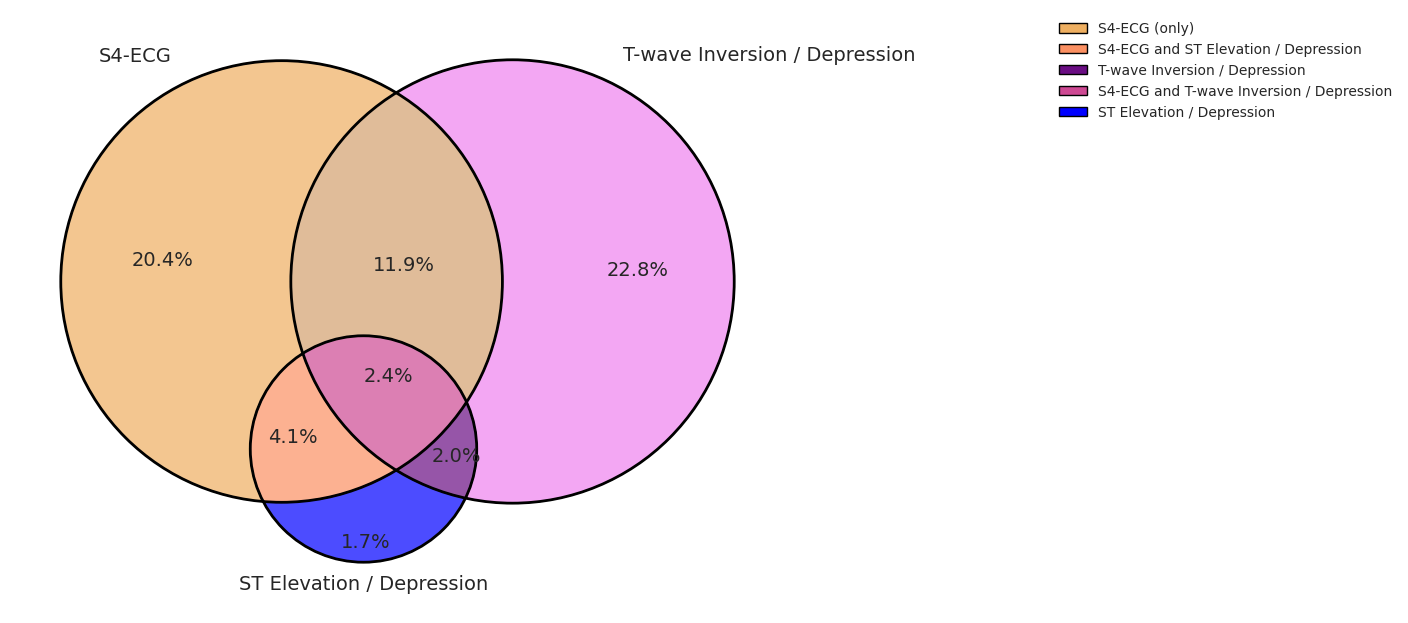

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Patch

SKIP_LABELS = False

tested_df['t_wave_abnormal_inversion'] = tested_df[['has_twave_inver', 'has_twave_abnormal']].any(axis=1)
tested_df['st_elevation_depression'] = tested_df[['has_depress', 'has_st_eleva']].any(axis=1)

# Total population
total_population = len(tested_df)

# Compute counts for each region
only_highrisk = len(tested_df[
    (tested_df['binary_preds_state']) &
    (~tested_df['t_wave_abnormal_inversion']) &
    (~tested_df['st_elevation_depression'])
])

only_twave = len(tested_df[
    (~tested_df['binary_preds_state']) &
    (tested_df['t_wave_abnormal_inversion']) &
    (~tested_df['st_elevation_depression'])
])  # Since 'low_ef' implies 'ef_available'

only_st_change = len(tested_df[
    (~tested_df['binary_preds_state']) &
    (~tested_df['t_wave_abnormal_inversion']) &
    (tested_df['st_elevation_depression'])
])

twave_and_st_change = len(tested_df[
    (~tested_df['binary_preds_state']) &
    (tested_df['t_wave_abnormal_inversion']) &
    (tested_df['st_elevation_depression'])
])

highrisk_and_st_change = len(tested_df[
    (tested_df['binary_preds_state']) &
    (~tested_df['t_wave_abnormal_inversion']) &
    (tested_df['st_elevation_depression'])
])

highrisk_and_twave = len(tested_df[
    (tested_df['binary_preds_state']) &
    (tested_df['t_wave_abnormal_inversion']) &
    (~tested_df['st_elevation_depression'])
])

all_three = len(tested_df[
    (tested_df['binary_preds_state']) &
    (tested_df['t_wave_abnormal_inversion']) &
    (tested_df['st_elevation_depression'])
])

neither = len(tested_df[
    (~tested_df['binary_preds_state']) &
    (~tested_df['t_wave_abnormal_inversion']) &
    (~tested_df['st_elevation_depression'])
])

# Sum up counts for verification
total_calculated = (
    only_highrisk +
    only_twave +
    only_st_change +
    highrisk_and_twave +
    highrisk_and_st_change +
    twave_and_st_change +
    all_three +
    neither
)


assert total_calculated == total_population, "Counts do not sum up to total population."

# Prepare subsets dictionary for venn3
subsets_dict = {
    '100': only_highrisk,
    '010': only_twave,              # Should be zero
    '110': highrisk_and_twave,      # Should be zero
    '001': only_st_change,  
    '101': highrisk_and_st_change,
    '011': twave_and_st_change,
    '111': all_three
}

# Plotting the Venn diagram
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-whitegrid')

# Create Venn diagram
venn = venn3(subsets=subsets_dict, set_labels=('S4-ECG', 'T-wave Inversion / Depression', 'ST Elevation / Depression'))

# Draw the outlines for each of the three sets
circles = venn3_circles(subsets=subsets_dict, linestyle='solid', linewidth=2)

# circles[0] -> "High Risk" circle outline
# circles[1] -> "Low EF" circle outline
# circles[2] -> "LVEF measured" circle outline
# circles[2].set_linestyle('dashed')     # Make 'LVEF measured' circle dashed
# circles[2].set_edgecolor('black')      # Set the edge color explicitly, if you like

# Calculate percentages for labels
def get_percentage(count):
    return f"{(count / total_population * 100):.1f}%"

subsets_dict = {
    '100': only_highrisk,
    '010': only_twave,              # Should be zero
    '001': only_st_change,    
    '110': highrisk_and_twave,      # Should be zero
    '101': highrisk_and_st_change,
    '011': twave_and_st_change,
    '111': all_three
}

# Set subset labels with percentages
for subset_id in ('100', '010', '001', '110', '101', '011', '111'):
    label = venn.get_label_by_id(subset_id)
    count = subsets_dict.get(subset_id, 0)
    if label and count > 0:
        label.set_text(get_percentage(count))
        
    elif label:
        label.set_text('')

# Set font sizes
for text in venn.set_labels:
    text.set_fontsize(14)
for text in venn.subset_labels:
    if text:
        text.set_fontsize(14)

# Customize colors
subset_ids = ['100', '010', '001', '110', '101', '011', '111']
set2_colors = ['#eeaf61', 'violet', 'blue', 'purple', '#fb9062', '#6a0d83', '#ce4993']
subset_colors = dict(zip(subset_ids, set2_colors))

for subset_id in subset_colors:
    patch = venn.get_patch_by_id(subset_id)
    if patch:
        patch.set_color(subset_colors[subset_id])
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

# **Set the circle for 'EF Available' to have a dotted line**
# Since 'EF Available' is the third set, it corresponds to set 'C'
ef_available_circle = venn.get_patch_by_id('001')
print(ef_available_circle)
if ef_available_circle:
    ef_available_circle.set_edgecolor('black')
    ef_available_circle.set_linestyle('dashed')

# Create a custom legend
legend_elements = [
    Patch(facecolor=subset_colors['100'], edgecolor='black', label='S4-ECG (only)'),
    Patch(facecolor=subset_colors['010'], edgecolor='black', label='T-wave Inversion / Depression'),
    Patch(facecolor=subset_colors['001'], edgecolor='black', label='ST Elevation / Depression'),
    Patch(facecolor=subset_colors['110'], edgecolor='black', label='S4-ECG and T-wave Inversion / Depression'),
    Patch(facecolor=subset_colors['101'], edgecolor='black', label='S4-ECG and ST Elevation / Depression'),
    Patch(facecolor=subset_colors['011'], edgecolor='black', label='T-wave Inversion / Depression and ST Elevation / Depression'),
    Patch(facecolor=subset_colors['111'], edgecolor='black', label='S4-ECG and T-wave Inversion / Depression and ST Elevation / Depression'),
]

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.8, 1)) 

if SKIP_LABELS:
    # Remove set labels (the three labels around the circles)
    for set_label in venn.set_labels:
        if set_label:
            set_label.set_text('')
    # Remove subset labels (the numbers inside the diagram)
    for subset_label in venn.subset_labels:
        if subset_label:
            subset_label.set_text('')

# Set title
#plt.title('Venn diagram of High Risk, Low EF, and EF Available', fontsize=16)
plt.savefig(f'venn_S4_vs_classical_features_vF.png', bbox_inches='tight', pad_inches=0.2)

# Display the plot
plt.show()
